# Demand Learning Comparison

This notebook runs several learning models on the market data created by the other notebooks of this repository.

The aim of this notebook is to provide a reproducible environment for research purposes. The used models are fully optimized as our focus is not on comparing their accuracy down to the last decimal place.
Hence, we do not claim that the results of this notebook allow to make conclusions about the accuracy, superiority, or short comings of a particular learning technique.

**Process:**
 * we read the data given as CSV files and parse them to create learning/evaluation data structures
   * Note: as the data generation requires some time, you can use a provided data set by using `USE_EXEMPLARY_DATA_SET = True`
 * we train several models (mostly using SciKit) on the given data and evaluate them accordingly
 * we analyse the results and display them in two tables:
   * model evalation: an overview of the runtimes, AIC, and McFadden results
   * market evaluation: an overview of the bias and SMRE for particular market situations
 * we create several visualizations to help the user interpreting the results

In [1]:
import math
import numpy as np
import pandas as pd

# little helper to compare against other implementations
# if True, the test sets used are not sampled but taken from the top
STATIC_TEST_SET = False

# we provide one exemplary data set
# set to True, if use exemplary data set
USE_EXEMPLARY_DATA_SET = True

def load_datasets(setting = 'S3'):
    global learning_X, learning_Y, prediction_X, prices, price_probas

    dataset_folder = ''
    ds_del = '\t'

    if USE_EXEMPLARY_DATA_SET:
        ds_del = ','
        size = 10
        datasets = [10] # we only added the smallest data set to the repository
        set_pos = datasets.index(size)
        dataset_folder = dataset_folder = 'settings/' + str(datasets[set_pos]) + 'k/'

    learning_data = np.loadtxt('{}demand_learning_data_{}.csv'.format(dataset_folder, setting), delimiter=ds_del)
    prediction_data = np.loadtxt('{}demand_prediction_data_{}.csv'.format(dataset_folder, setting), delimiter=ds_del)

    price_data = np.loadtxt('{}PEW_comparison_{}.csv'.format(dataset_folder, setting), delimiter=ds_del)

    _, learning_X, learning_Y = np.hsplit(learning_data, [1, learning_data.shape[1]-1])
    
    # as of now, we compare approach that predict wheather
    # an item is sold or not.
    vpmin_1 = np.vectorize(lambda x: min(1,x))
    learning_Y = vpmin_1(learning_Y.ravel())
    
    prediction_X = np.hsplit(prediction_data, [2, prediction_data.shape[1]])[1]

    prices, price_probas, price_probas_rest, _ = np.hsplit(price_data, [2, 3, price_data.shape[1]+1])

In [2]:
def calculate_loglikelihood(probas, Y):
    # fort the case of p = 0.0, we "cheat" a little bit
    return sum([(Y[i]*math.log(max(float("10e-10"),probas[i])) + (1 - min(1, Y[i])) * math.log(max(float("10e-10"),(1 - probas[i])))) for i in range(len(Y))])

def calculate_AIC(probas, Y):
    num_features = prediction_X.shape[1]
    return -2 * calculate_loglikelihood(probas, Y) + 2 * num_features

def process_prediction(predictions, predictions_are_tuples = True):
    if predictions_are_tuples:
        ret = [item[1] for item in predictions]
    else:
        ret = predictions

    # Ensuring (0,1) is only needed for Linear (non-logistic) regressions.
    # It's rather unclear but sufficient for our tests
    return [min(1, max(0, item)) for item in ret]

The next cell calculates the AIC and Loglikelihood for the null model. We will require both values later to determine the McFadden values.

In [3]:
def calc_null_model(learn_X, learn_Y):
    model = linear_model.LogisticRegression()
    # regressors return scalar values

    test_size = 0.2
    logl_factor = test_size / (1 - test_size) # scale factor for initial logl of null model

    if STATIC_TEST_SET:
        X_train = learning_X[:(round(len(learning_X)*(1-test_size))),:]
        X_test = learning_X[(round(len(learning_X)*(1-test_size))):,:]
        y_train = learning_Y[:(round(len(learning_Y)*(1-test_size)))]
        y_test = learning_Y[(round(len(learning_Y)*(1-test_size))):]
    else:
        X_train, X_test, y_train, y_test = train_test_split(learn_X, learn_Y, test_size=test_size, random_state=17)

    model.fit(np.zeros((np.shape(X_train)[0],9)), y_train)

    # validate against training set for AIC calculation
    probas = model.predict_proba(X_test)

    probas = process_prediction(probas, True)
    aic = calculate_AIC(probas, y_test)
    logl = calculate_loglikelihood(probas, y_test)

    return (aic, logl)

The next cell contains the main learning method `fit_and_predict`.
Whether we randomly select the test set or simply by using the last `n%` depends on the variable `STATIC_TEST_SET`.



In [4]:
import time
from sklearn.model_selection import train_test_split

def fit_and_predict(name, learn_X, learn_Y, test_Y, model, predict_method):
    # regressors return scalar values
    predictions_are_tuples = True
    if predict_method == 'predict':
        predictions_are_tuples = False

    test_size = 0.2
    logl_factor = test_size / (1 - test_size) # scale factor for initial logl of null model

    if STATIC_TEST_SET:
        X_train = learning_X[:(round(len(learning_X)*(1-test_size))),:]
        X_test = learning_X[(round(len(learning_X)*(1-test_size))):,:]
        y_train = learning_Y[:(round(len(learning_Y)*(1-test_size)))]
        y_test = learning_Y[(round(len(learning_Y)*(1-test_size))):]
    else:
        X_train, X_test, y_train, y_test = train_test_split(learn_X, learn_Y, test_size=test_size, random_state=17)
    start_fit = time.time()
    model.fit(X_train, y_train)
    runtime_fit = (time.time() - start_fit) * 1000 # ms

    # validate against training set for AIC calculation
    start_predict = time.time()
    probas = getattr(model, predict_method)(X_test)
    runtime_predict = (time.time() - start_predict) * 1000 # ms
    runtime_predict = runtime_predict / len(X_test)

    probas = process_prediction(probas, predictions_are_tuples)
    aic = calculate_AIC(probas, y_test)
    logl = calculate_loglikelihood(probas, y_test)
    logl_factor = 1.0
    mcf = 1 - (logl / (logl_0 * logl_factor))

    # validate against evaluation set
    model.fit(learn_X, learn_Y)
    probas = getattr(model, predict_method)(test_Y)
    probas = process_prediction(probas, predictions_are_tuples)

#     mname = str(model.__class__)
#     mname = mname[mname.rfind('.')+1:mname.find("'>")]

    return [name, runtime_fit, runtime_predict, aic, logl, mcf, probas]

In [5]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

def plot_probability_graphs(p, setting_id):
    # converting to "long form"
    p_melted = pd.melt(p, id_vars=['Situation', 'Price'], var_name=['Method'])
    
    # filtering for RFs (too bad estimates)
    p_melted = p_melted[p_melted.Method != 'Extreme Gradient Boosting - Regressor']
    p_melted = p_melted[p_melted.Method != 'Gradient Boosting Trees']
    p_melted = p_melted[p_melted.Method != 'Random Forest - Regressor']
    p_melted = p_melted[p_melted.Method != 'Random Forest - Classification']
    p_melted = p_melted[p_melted.Method != 'Multi-Layer Perceptron - Regressor']

    g = sns.FacetGrid(p_melted, col='Situation', col_wrap=4, hue='Method')
    g = (g.map(plt.plot, "Price", "value").add_legend().set_ylabels('Probability'))
    g.savefig("setting_{}.pdf".format(setting_id))
    return g

In [7]:
def calculate_price_point_table(df):
    out = pd.DataFrame(columns=['Price', 'Method', 'dist__sum', 'smre', 'rel_dist__sum', 'dist__abs_sum', 'profit_dist__abs_sum'])
    for price, v in df.groupby(['Price']):
        cols = list(v) # get column names
        cols.remove('Price')
        cols.remove('Situation')
        cols.remove('Actual Probabilities')
        for method in cols:
            row = [price, method]
            row.append((v['Actual Probabilities']-v[method]).mean())
            row.append(np.power((np.sqrt(np.absolute(v['Actual Probabilities']-v[method]))).mean(), 2))
            row.append(((v['Actual Probabilities']-v[method]) / v['Actual Probabilities']).mean())
            row.append((v['Actual Probabilities']-v[method]).abs().mean())
            row.append((v['Actual Probabilities']*price-v[method]*price).abs().mean())
            out.loc[len(out)]=row

    return out

In [9]:
from sklearn import neural_network
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
import xgboost as xgb

def learn():
    overview = pd.DataFrame(columns=['Model Name', 'Runtime Fitting (ms)', 'Runtime Prediction (ms per item)', 'AIC', 'LogLikelihood', 'McFadden Pseudo R^2'])
    probas = pd.DataFrame(prices, columns=['Situation', 'Price'])
    
    models = {'Logistic Regression':
                  {'short_name': 'LogR',
                   'model': linear_model.LogisticRegression(),
                   'predict_method': 'predict_proba'
                  },
              'Linear Regression':
                  {'short_name': 'LinR',
                   'model': linear_model.LinearRegression(),
                   'predict_method': 'predict'
                  },
              'Extreme Gradient Boosting - Classifier':
                  {'short_name': 'XGB',
                   'model': xgb.XGBClassifier(),
                   'predict_method': 'predict_proba'
                  },
              'Extreme Gradient Boosting - Regressor':
                  {'short_name': 'XGB_Reg',
                   'model': xgb.XGBRegressor(),
                   'predict_method': 'predict'
                  },
              'Gradient Boosting Trees':
                  {'short_name': 'GBT',
                   'model': ensemble.GradientBoostingRegressor(),
                   'predict_method': 'predict'
                  },
              'Random Forest - Classification':
                  {'short_name': 'RFC',
                   'model': ensemble.RandomForestClassifier(),
                   'predict_method': 'predict_proba'
                  },
              'Random Forest - Regressor':
                  {'short_name': 'RFR',
                   'model': ensemble.RandomForestRegressor(),
                   'predict_method': 'predict'
                  },
              'Multi-Layer Perceptron - Classifier':
                  {'short_name': 'MLP',
                   'model': neural_network.MLPClassifier(),
                   'predict_method': 'predict_proba'
                  },
              'Multi-Layer Perceptron - Regressor':
                  {'short_name': 'MLP_Reg',
                   'model': neural_network.MLPRegressor(),
                   'predict_method': 'predict'
                  },
              'Support Vector Machine':
                  {'short_name': 'SVM',
                   'model': svm.SVC(probability=True),
                   'predict_method': 'predict_proba'
                  }
             }
    
    # all models are executed by default
    for model in models:
        models[model]['execute'] = True

    # disable particular models for tests (e.g., SVM due to runtime issues)
#     models['Gradient Boosting Trees']['execute'] = False
#     models['Random Forest - Classification']['execute'] = False
#     models['Random Forest - Regressor']['execute'] = False
#     models['Multi-Layer Perceptron - Regressor']['execute'] = False
#     models['Extreme Gradient Boosting - Regressor']['execute'] = False
#     models['Support Vector Machine']['execute'] = False

    for k, v in models.items():
        if not v['execute']: continue

        exec_meth = v['predict_method']
        ret = fit_and_predict(k, learning_X, learning_Y, prediction_X, v['model'], exec_meth)
        overview.loc[len(overview)]=ret[:-1]
        probas[ret[0]] = ret[-1]

    probas['Actual Probabilities'] = price_probas

    return (overview, probas)

pricing_setting = 'S3'
load_datasets(pricing_setting)

# determine null model
aic_0, logl_0 = calc_null_model(learning_X, learning_Y)
print(f"Null model: \n\tAIC: {aic_0:,}\n\tLoglikelihood: {logl_0:,}")

res = learn()
overview = res[0]
probas = res[1]

display(overview)

Null model: 
	AIC: 1,077.3495648963965
	Loglikelihood: -529.6747824481982


,Model Name,Runtime Fitting (ms),Runtime Prediction (ms per item),AIC,LogLikelihood,McFadden Pseudo R^2
0,Logistic Regression,25.786877,0.000095,849.948222,-415.974111,0.232876
1,Linear Regression,1.466990,0.000044,887.131210,-434.565605,0.198590
2,Extreme Gradient Boosting - Classifier,314.920902,0.003058,846.778122,-414.389061,0.235799
3,Extreme Gradient Boosting - Regressor,285.857916,0.001740,844.119794,-413.059897,0.238250
4,Gradient Boosting Trees,256.907225,0.001177,848.126815,-415.063408,0.234556
5,Random Forest - Classification,36.608934,0.001315,2559.364116,-1270.682058,-1.343344
6,Random Forest - Regressor,64.807892,0.000950,2589.183175,-1285.591587,-1.370840
7,Multi-Layer Perceptron - Classifier,271.489620,0.000802,850.474965,-416.237483,0.232390
8,Multi-Layer Perceptron - Regressor,396.394968,0.000759,1065.592254,-523.796127,0.034035
9,Support Vector Machine,4191.220999,0.039034,1098.351633,-540.175817,0.003828


In [10]:
res_table = calculate_price_point_table(probas)

In [11]:
# We'll filter for 3 exemplary prices: 4, 8, & 12
filtered = res_table[(res_table.Price % 4 == 0) & (res_table.Price > 0.0)]

display(filtered)

,Price,Method,dist__sum,smre,rel_dist__sum,dist__abs_sum,profit_dist__abs_sum
400,4.0,Logistic Regression,0.035518,0.055005,0.218674,0.068321,0.273285
401,4.0,Linear Regression,0.034604,0.056202,0.134843,0.065855,0.263421
402,4.0,Extreme Gradient Boosting - Classifier,0.025246,0.067900,0.189106,0.080511,0.322045
403,4.0,Extreme Gradient Boosting - Regressor,0.027272,0.067460,0.171812,0.077621,0.310484
404,4.0,Gradient Boosting Trees,0.006916,0.086676,0.085456,0.102770,0.411081
405,4.0,Random Forest - Classification,0.003050,0.087886,-0.042494,0.098170,0.392680
406,4.0,Random Forest - Regressor,-0.045795,0.106857,-0.409384,0.127161,0.508644
407,4.0,Multi-Layer Perceptron - Classifier,0.058910,0.073919,0.324277,0.086012,0.344049
408,4.0,Multi-Layer Perceptron - Regressor,-0.012892,0.045836,-0.214511,0.054945,0.219779
409,4.0,Support Vector Machine,0.080798,0.093621,0.224941,0.110698,0.442794


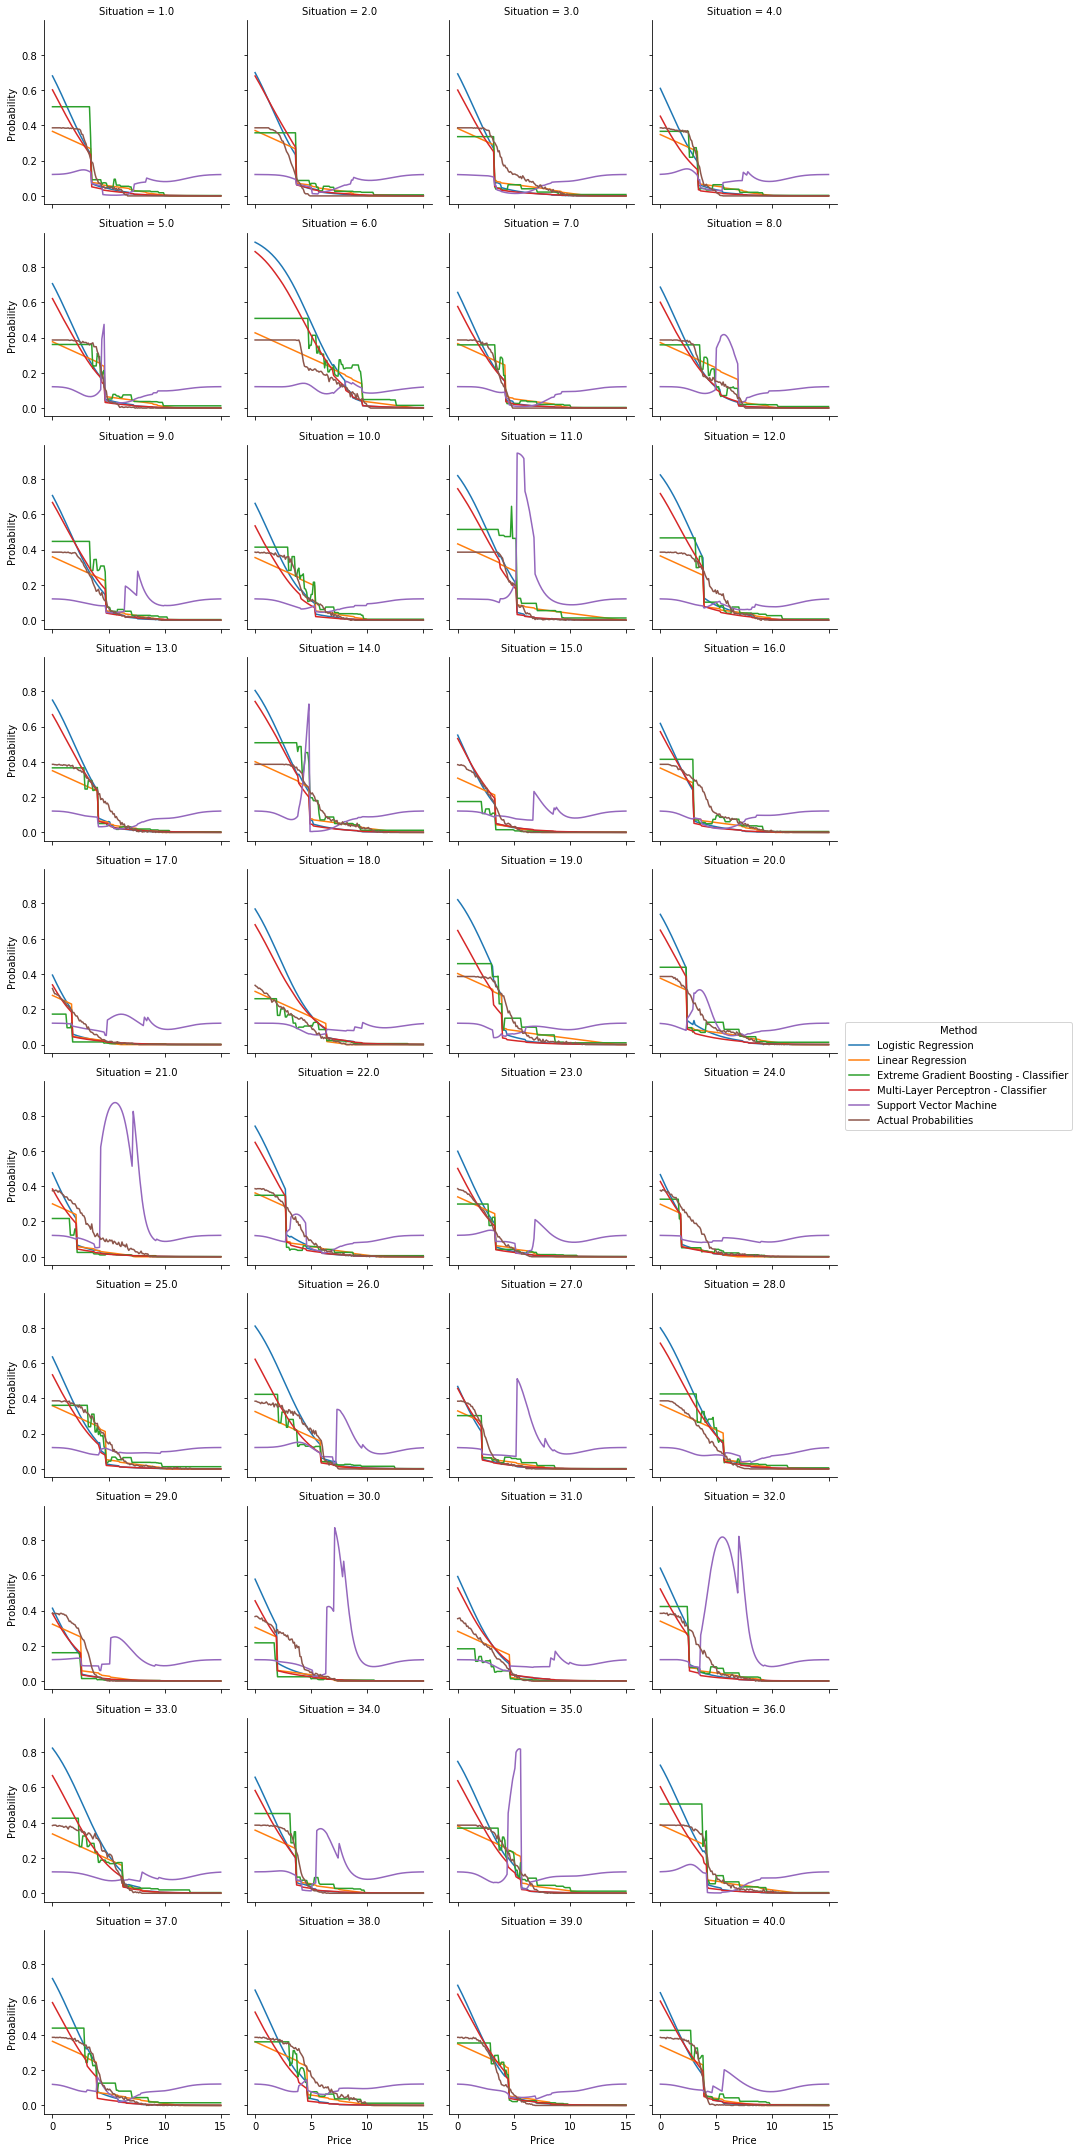

In [12]:
g = plot_probability_graphs(probas, 'S1')
display(g)

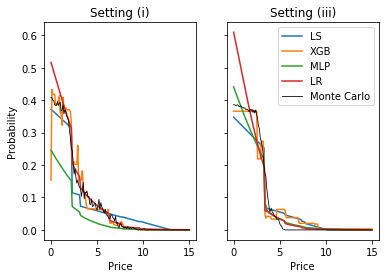

In [13]:
import matplotlib

# fixes problems with ACM's PreFlight compiler which complains about type 3 fonts
# see: http://phyletica.org/matplotlib-fonts/
matplotlib.rcParams['text.usetex'] = True

def plot_paper_graph__setting_comparison(situations):
    f, axes = plt.subplots(1, len(situations), sharey=True)

    i = 0
    for k, p in situations.items():
        axis = axes[i]
        plt.rcParams["figure.figsize"] = (6,3)

        cols = {'Price': 'Price',
                'Logistic Regression': 'LR',
                'Linear Regression': 'LS',
                'Extreme Gradient Boosting - Classifier': 'XGB',
                'Multi-Layer Perceptron - Classifier': 'MLP',
                'Actual Probabilities': 'Monte Carlo'}
        p = p.filter(items=cols.keys())

        # renaming
        p.rename(columns=cols, inplace=True)

        for col in list(cols.values())[1:]:
            # axx.plot(p.Price, p[[col]], label=col)
            pass # disabling to ensure 'nice order of appearance'

        # this is a manual fix to ensure that the order to drawing
        # is optimized for the reader (i.e., models being far off
        # are drawn first as they do less clutter the visual result)
        axis.plot(p.Price, p[['LS']], label='LS')
        axis.plot(p.Price, p[['XGB']], label='XGB')
        axis.plot(p.Price, p[['MLP']], label='MLP')
        axis.plot(p.Price, p[['LR']], label='LR')
        axis.plot(p.Price, p[['Monte Carlo']], 'k-', label='Monte Carlo', linewidth=0.8)

        axis.set_xlabel('Price')
        if i == 0:
            axis.set_ylabel('Probability') # set on left most graph only
        plt.legend()
        axis.set_title('Setting {}'.format(k))
        
        i = i + 1

    plt.show()
    f.subplots_adjust(hspace=0.0)
    f.savefig("dm__setting_comparison.pdf", bbox_inches='tight')


# we select to exemplary situations, that nicely show the expected effects
# of the settings and where no model is particularly good or bad.
# For the paper, we selected situation 9 of setting (i) and 4 of (iii) 
selected_situations = {}
load_datasets('S1')
res = learn()
probas_filt = res[1]
selected_situations['(i)'] = probas_filt[probas_filt.Situation == 9]
load_datasets('S3')
res = learn()
probas_filt = res[1]
selected_situations['(iii)'] = probas_filt[probas_filt.Situation == 4]

plot_paper_graph__setting_comparison(selected_situations)